In [141]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.optim as optim


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [142]:
path = '/Users/samyu1/Downloads/lfw'

In [143]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [144]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


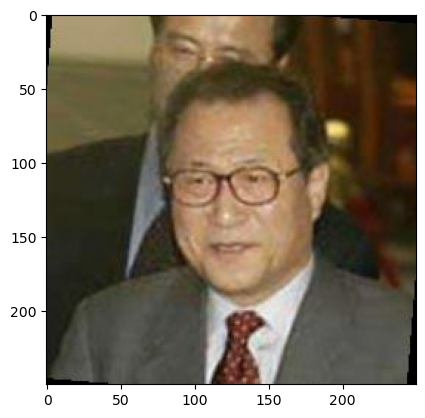

In [146]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 


### Applications

1. **Autoencoders (AEs)**:
   - **Dimensionality Reduction**: Often used as a more powerful alternative to PCA or linear autoencoders.
   - **Feature Learning**: Can learn complex, non-linear transformations for feature extraction.
   - **Denoising**: AEs can be trained to remove noise from data (denoising autoencoders).

2. **Variational Autoencoders (VAEs)**:
   - **Generative Modeling**: VAEs are generative models and can generate new data samples that are similar to the training data.
   - **Anomaly Detection**: Effective in identifying data points that differ significantly from the training data.
   - **Semi-supervised Learning**: Can be used in scenarios with limited labeled data due to their generative capabilities.

### Architecture

1. **Autoencoders (AEs)**:
   - Consist of an encoder and a decoder. The encoder compresses the input into a lower-dimensional latent space, and the decoder reconstructs the output from this representation.
   - The latent space is a bottleneck in the network, forcing the AE to learn a compressed representation of the input data.

2. **Variational Autoencoders (VAEs)**:
   - Similar encoder-decoder structure, but with a crucial difference in the latent space representation.
   - The encoder in a VAE maps inputs to a distribution (typically Gaussian) in the latent space. It produces two outputs for each input: a mean (mu) and a variance (logvar).
   - VAEs use the reparameterization trick in the latent space to enable gradient descent through random sampling.

### Loss Function

1. **Autoencoders (AEs)**:
   - The loss function is typically the reconstruction error between the input and the output. Common choices are Mean Squared Error (MSE) for continuous data or Binary Cross-Entropy for binary data.
   - The goal is to minimize this reconstruction error.

2. **Variational Autoencoders (VAEs)**:
   - The loss function in VAEs is more complex, consisting of two terms: a reconstruction loss (like AEs) and a regularization term.
   - The reconstruction loss ensures the decoded samples match the original inputs.
   - The regularization term, often the Kullback-Leibler (KL) divergence, ensures the learned distribution in the latent space approximates the prior distribution (usually a standard Gaussian). This term encourages the model to learn well-formed, continuous, and complete representations of the input data.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [147]:
class VAE(nn.Module):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.MaxPool2d(1, stride=1),
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self._to_linear = None
        self._reshaped_size = None
        self._compute_layer_dimensions(3, 250, 250)
        self.fc_mu = nn.Linear(self._to_linear, latent_dims)
        self.fc_logvar = nn.Linear(self._to_linear, latent_dims)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, self._to_linear),
            nn.Unflatten(1, (-1, 32, 31, 31)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(True),
            nn.Tanh()
        )

    def _compute_layer_dimensions(self, channels, height, width):
        with torch.no_grad():
            input_tensor = torch.zeros(1, channels, height, width)
            output_tensor = self.encoder(input_tensor)
            self._to_linear = int(torch.flatten(output_tensor, start_dim=1).size(1))
            self._reshaped_size = output_tensor.shape[1:]

    def encode(self, x):
        x_encoded = self.encoder(x)
        x_encoded = torch.flatten(x_encoded, start_dim=1)
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)
        return mu, logvar

    def sample_latent_space(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_latent_space(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [148]:
images, _ = next(iter(dataloader))
image = images[0].unsqueeze(0)
reconstructed_img, mu, logvar = vae(image)
print("Shape of mu:", mu.shape)
print("Shape of logvar:", logvar.shape)
print("Shape of reconstructed image:", reconstructed_img.shape)
reconstructed_img, mu, logvar = vae(image)
print("Shape of reconstructed image in forward pass:", reconstructed_img.shape)


Shape of mu: torch.Size([1, 20])
Shape of logvar: torch.Size([1, 20])
Shape of reconstructed image: torch.Size([1, 3, 250, 250])
Shape of reconstructed image in forward pass: torch.Size([1, 3, 250, 250])


Sampling from the Latent Space:

First, you need to sample random points from the latent space. The latent space in a VAE typically follows a Gaussian distribution (mean = 0, variance = 1).
You can sample points from this distribution by using the mean (
�
μ) and standard deviation (
�
σ) vectors that are output by the VAE's encoder network for a given input.
Decoding the Latent Samples:

Take the sampled points from step 1 and pass them through the decoder network of the VAE.
The decoder network will transform these points back into data space, generating new samples.
Visualization:

The output of the decoder in step 2 will be the generated samples in the data space.
You can visualize these generated samples to see what the VAE has learned about the data distribution in the latent space.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [149]:
learning_rate = 0.001
optim = optim.Adam(vae.parameters(), lr=learning_rate)

In [150]:
def vae_loss_function(reconstructed_x, original_x, mu, logvar):
  
    mse_loss = F.mse_loss(reconstructed_x, original_x, reduction='sum')

    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = mse_loss + kld_loss

    return total_loss

In [151]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

latent_dims = 20
vae = VAE(latent_dims)

total_params = count_parameters(vae)
print(f"Total number of parameters: {total_params}")


Total number of parameters: 7757803



1. **Reconstruction Loss**:
   - **Purpose**: The reconstruction loss measures how accurately the VAE can reconstruct the input data from the latent space representation.
   - **Computation**: It quantifies the difference between the original input data and the data reconstructed by the VAE's decoder. Commonly, Mean Squared Error (MSE) or a similar loss function is used for this purpose.
   - **Goal**: The primary objective of the reconstruction loss is to ensure that the VAE can faithfully reconstruct input data, preserving its essential features and minimizing information loss. This is crucial for maintaining data fidelity.

2. **Regularization Loss (Kullback-Leibler Divergence, KL Divergence)**:
   - **Purpose**: The regularization loss, often represented by the Kullback-Leibler (KL) divergence, encourages the latent space of the VAE to follow a predefined distribution, typically a standard normal distribution (mean 0, variance 1).
   - **Computation**: It quantifies the divergence between the actual distribution of latent variables (represented by `mu` and `logvar`) and the desired standard normal distribution.
   - **Goal**: The primary goal of the regularization loss is to regularize the latent space, making it well-structured, continuous, and meaningful. This regularization encourages latent representations to be distributed in a way that facilitates the generation of new data samples from the latent space. It also prevents overfitting and helps the VAE to learn a useful and structured latent representation of the data.



##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [152]:

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)


num_epochs = 10

vae.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        
        reconstructed_images, mu, logvar = vae(images)

        loss = vae_loss_function(reconstructed_images, images, mu, logvar)
        if not torch.isfinite(loss):
            print(f"Loss is NaN or Inf at epoch {epoch+1}")
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

torch.save(vae.state_dict(), 'vae_model.pth')

vae.eval()
with torch.no_grad():
    images, _ = next(iter(dataloader))
    images = images.to(device)
    reconstructed_images, _, _ = vae(images)
    images_to_display = torch.cat((images[:8], reconstructed_images[:8]))
    images_to_display = images_to_display.cpu().permute(0, 2, 3, 1).numpy()
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(18, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow((images_to_display[i] * 0.5 + 0.5))
        ax.axis('off')
    plt.show()


Epoch 1/10, Loss: 151352.3567
Epoch 2/10, Loss: 106007.5465
Epoch 3/10, Loss: 83933.3683
Epoch 4/10, Loss: 74578.9371
Epoch 5/10, Loss: 70465.6532
Epoch 6/10, Loss: 68590.3376
Epoch 7/10, Loss: 67594.4432
Epoch 8/10, Loss: 66939.2161
Epoch 9/10, Loss: 66509.6424
Epoch 10/10, Loss: 66184.5765


If the loss stagnates during training, troubleshooting involves a systematic approach.Begin by reviewing data preprocessing for consistency and proper normalization. Adjust the learning rate and experiment with different optimizers. Check the model's complexity and architecture, considering additions if necessary. Monitor loss curves for signs of overfitting. Employ techniques like data augmentation, label verification, and adjustments to batch sizes and activation functions. Implement regularization methods and evaluate the suitability of the chosen loss function. Systematically address these factors to diagnose and resolve the issue of a stagnant or increasing loss during training."

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

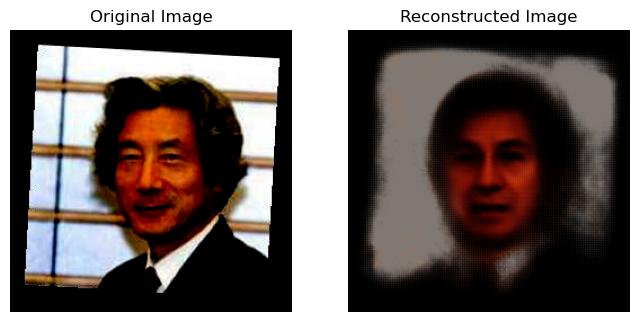

In [163]:
images, _ = next(iter(dataloader))
image = images[0].unsqueeze(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image = image.to(device)

reconstructed_img, mu, logvar = vae(image)

original_img = image.squeeze(0).detach().cpu()
reconstructed_img = reconstructed_img.squeeze(0).detach().cpu()

original_img_np = original_img.permute(1, 2, 0).numpy().clip(0, 1)
reconstructed_img_np = reconstructed_img.permute(1, 2, 0).numpy().clip(0, 1)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(original_img_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_img_np)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()
